## **Assignment 8: Ensemble Learning for Complex Regression Modeling on Bike Share Data**

## **Introduction**
This project focuses on predicting the hourly demand for bike rentals using the Bike Sharing Dataset. The target variable (cnt) is influenced by weather and time-related factors, making it a non-linear regression problem.

To improve prediction accuracy, we apply and compare three ensemble learning techniques—Bagging, Boosting, and Stacking—and evaluate how they help reduce variance, reduce bias, and improve overall generalization compared to a baseline model.

---

## **PART -A)** **Data Preprocessing and Baseline**

**Importing Necessary Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, StackingRegressor

import warnings
warnings.filterwarnings("ignore")

 ## **1.Load and Prepare Data**

In [2]:
df = pd.read_csv("hour.csv")

-> Below we check that there is no null values in any features

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


So, There are total **17379 entries with 17 columns** and none of them have null values .

Now , We dropped Necessary Columns not Required for our Analysis like :    ['instant', 'dteday', 'casual', 'registered']

In [4]:
# Drop irrelevant columns
df = df.drop(['instant', 'dteday', 'casual', 'registered'], axis=1)

Check the **Updated Dataframe** info :

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17379 non-null  int64  
 1   yr          17379 non-null  int64  
 2   mnth        17379 non-null  int64  
 3   hr          17379 non-null  int64  
 4   holiday     17379 non-null  int64  
 5   weekday     17379 non-null  int64  
 6   workingday  17379 non-null  int64  
 7   weathersit  17379 non-null  int64  
 8   temp        17379 non-null  float64
 9   atemp       17379 non-null  float64
 10  hum         17379 non-null  float64
 11  windspeed   17379 non-null  float64
 12  cnt         17379 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 1.7 MB


**Now there are 13 columns and no of entries remain same (17379).**

**Visualizing the distribution of bike rental counts in the dataset.**


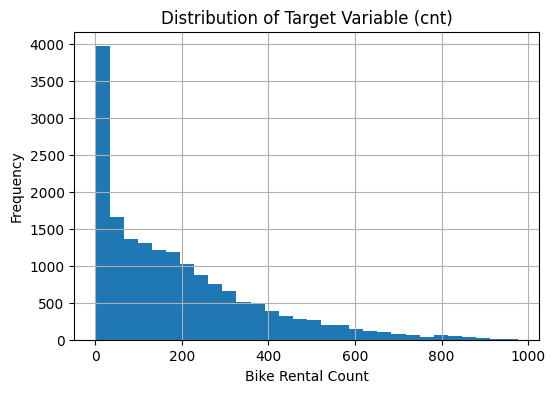

In [6]:
df["cnt"].hist(bins=30, figsize=(6,4))
plt.xlabel("Bike Rental Count")
plt.ylabel("Frequency")
plt.title("Distribution of Target Variable (cnt)")
plt.show()


Distribution is maximum around low values and then decreases for higher bike Rental Count .

**Checking how temperature influences bike rental demand.**

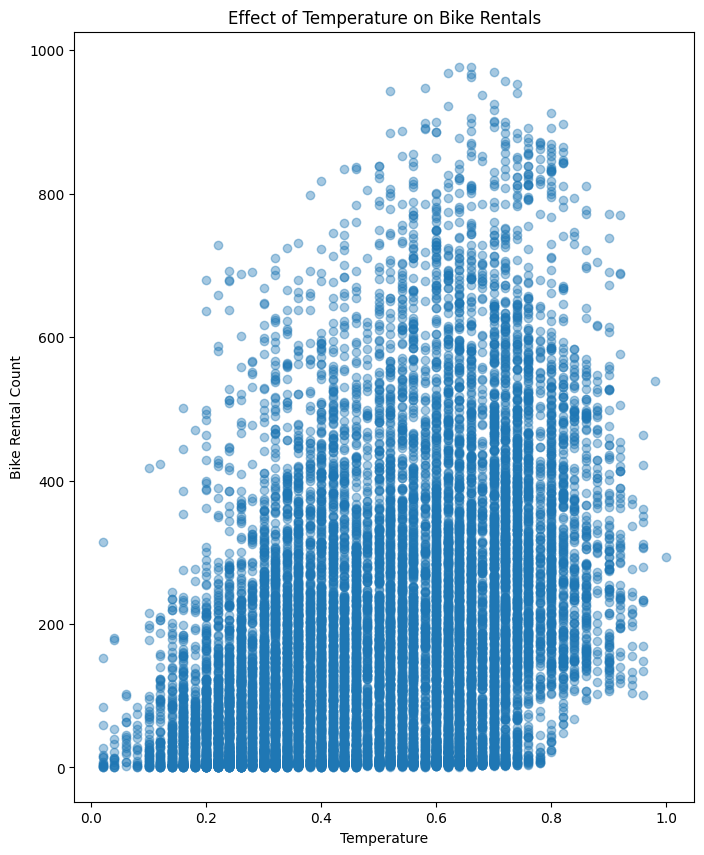

In [7]:
plt.figure(figsize=(8,10))
plt.scatter(df["temp"], df["cnt"], alpha=0.4)
plt.xlabel("Temperature")
plt.ylabel("Bike Rental Count")
plt.title("Effect of Temperature on Bike Rentals")
plt.show()


OBSERVATION :**As temperature increases, the number of bike rentals generally rises, indicating people rent more bikes in warmer weather.**

---

Now ,Separate the Input Features & Target Variables :

In [8]:
X = df.drop("cnt", axis=1)
y = df["cnt"]

In [9]:
print(X.shape)

(17379, 12)


**Eventually ,We performed One-Hot Encoding on the categorial Features :**

In [10]:
X = df.drop("cnt", axis=1)
categorical_cols = ['season', 'weathersit', 'mnth', 'hr', 'weekday', 'workingday']
for col in categorical_cols:
    X[col] = X[col].astype('category')

In [11]:
preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(drop='first'), categorical_cols)],
    remainder='passthrough'
)

Look at the column size , it has increased from 12 to 52 .

In [12]:
X = preprocessor.fit_transform(X)
print(X.shape)

(17379, 53)


In [13]:
X_encoded_df = pd.DataFrame(X.toarray() if hasattr(X, "toarray") else X)

print("Initial entries of X after One-Hot Encoding:")
print(X_encoded_df.head())

Initial entries of X after One-Hot Encoding:
    0    1    2    3    4    5    6    7    8    9   ...   43   44   45   46  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.0  0.0   

    47   48    49      50    51   52  
0  0.0  0.0  0.24  0.2879  0.81  0.0  
1  0.0  0.0  0.22  0.2727  0.80  0.0  
2  0.0  0.0  0.22  0.2727  0.80  0.0  
3  0.0  0.0  0.24  0.2879  0.75  0.0  
4  0.0  0.0  0.24  0.2879  0.75  0.0  

[5 rows x 53 columns]


#**2.Train/Test Split:**

**Split the preprocessed data into training and testing sets**

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# **3. Baseline Model (Single Regressor):**

---

**Decision Tree Regressor** :


We perform hyperparameter tuning using GridSearchCV to find the best Decision Tree configuration that minimizes prediction error.

After training, we evaluate the optimized model by calculating the Root Mean Squared Error (RMSE) on the test set.

In [15]:
dt_params = {
    "reg__criterion": ["squared_error", "friedman_mse"],
    "reg__max_depth": [6],
    "reg__min_samples_split": [2, 5, 10, 20],
    "reg__min_samples_leaf": [1, 2, 4, 6],
    "reg__max_features": [None, "sqrt", "log2"]
}

-> Below Created a pipeline with a Decision Tree regressor, perform grid search over dt_params using 3-fold CV and negative RMSE scoring, fit it on training data, predict on test data, and compute the RMSE of predictions.

In [16]:
dt_pipeline = Pipeline(steps=[
    ("reg", DecisionTreeRegressor(random_state=42))
])

dt_model = GridSearchCV(dt_pipeline, dt_params, cv=3, scoring="neg_root_mean_squared_error")
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
dt_rmse = np.sqrt(mean_squared_error(y_test, dt_pred))

In [17]:
print(f"Decision Tree RMSE: {dt_rmse:.3f}")

Decision Tree RMSE: 118.513


**We get RMSE of Best Decision Tree Regressor as 118.513**

---

**Linear Regression** :

We build The Linear Regression model and evaluated directly, producing its RMSE on the test data.

---

In [45]:
# Linear Regression Baseline
lr_model = Pipeline(steps=[
    ("lr", LinearRegression())
])


-> Train the Model on training Dataset

In [46]:
lr_model.fit(X_train, y_train)

Pipeline(steps=[('lr', LinearRegression())])

-> Predict on Test Data and calculate RMSE for the Model :

In [47]:
lr_pred = lr_model.predict(X_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))


In [48]:
print(f"Linear Regression RMSE: {lr_rmse:.3f}")

Linear Regression RMSE: 100.446


**We get RMSE of  Linear Regression as 100.446**

---

## **-> Choose the Better Model as Baseline Model :**

In [23]:
# Baseline Model
baseline_rmse = min(dt_rmse, lr_rmse)
baseline_model = "Decision Tree" if dt_rmse < lr_rmse else "Linear Regression"

print("Baseline Model:", baseline_model)

Baseline Model: Linear Regression


In [24]:
print(f"Baseline RMSE: {baseline_rmse:.3f}")

Baseline RMSE: 100.443


**We choose Linear Regression Model as Baseline Model as it has Low RMSE value(100.443) than Decision Tree Regressor(118.513)**

# **Part B: Ensemble Models**



### **1. Bagging (Variance Reduction):**
---

### *Hypothesis1: Bagging primarily targets variance reduction.*

We will Build the Model on our Hypothesis and will check validity of Hypothesis in the end .

---



In [25]:
# Bagging Regressor
bag_model = Pipeline(steps=[
    ("bag", BaggingRegressor(
        estimator=DecisionTreeRegressor(max_depth=6),
        n_estimators=80,
        random_state=42))
])

In [26]:
bag_model.fit(X_train, y_train)
bag_pred = bag_model.predict(X_test)
bag_rmse = np.sqrt(mean_squared_error(y_test, bag_pred))

In [27]:
print(f"\nBagging RMSE: {bag_rmse:.3f}")


Bagging RMSE: 112.338


**We get RMSE value from Bagging Regressor as 112.353**

## **Is Our Hypothesis 1 Valid ?**

- **The hypothesis stated that Bagging primarily reduces variance.**
The results support this hypothesis because the Bagging Regressor achieved a lower RMSE (112.353) compared to the single Decision Tree model (118.513).

- Since Bagging trains multiple Decision Trees on different bootstrap samples and averages their predictions, it reduces the variance of the model, making the predictions more stable and less sensitive to noise in the training data.

Therefore, **Bagging effectively improved generalization performance and validated the hypothesis.**

---


## **2.Boosting (Bias Reduction):**

## *Hypothesis 2 : Boosting primarily targets bias reduction.*

Now, we will build the Gradient Boosting Regressor based on the hypothesis that boosting reduces model bias. We will test it on the test data and calculate the RMSE to evaluate its performance

**Note :** For the Camparison in the end ,we have used same parameters as Bagging Regressor Model .

In [28]:
# Gradient Boosting Regressor
gbr_model = Pipeline(steps=[
    ("gbr", GradientBoostingRegressor(
        n_estimators=80,        # same number of trees
        max_depth=6,           # same depth for each tree
        random_state=42
    ))
])

gbr_model.fit(X_train, y_train)
gbr_pred = gbr_model.predict(X_test)

 Showing which features are most influential in the Gradient Boosting model.


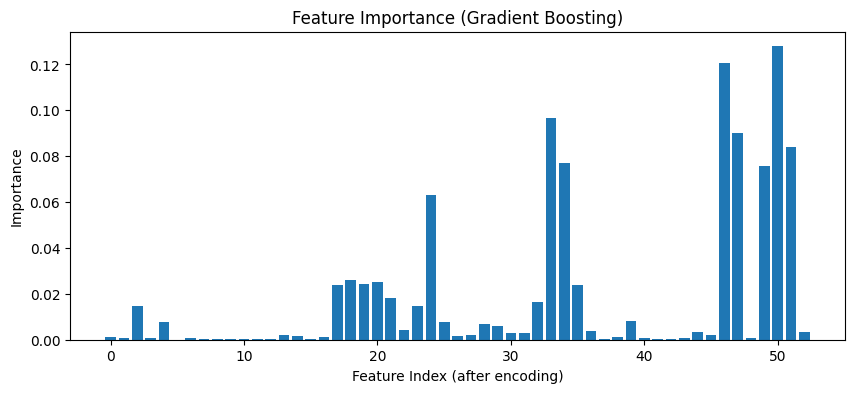

In [29]:
gbr = gbr_model.named_steps["gbr"]
importances = gbr.feature_importances_

plt.figure(figsize=(10,4))
plt.bar(range(len(importances)), importances)
plt.title("Feature Importance (Gradient Boosting)")
plt.xlabel("Feature Index (after encoding)")
plt.ylabel("Importance")
plt.show()

Feature '50' & Feature '46' are the most Important features for our Model.

**Now Calculate RMSE for the Model :**

In [30]:
gbr_rmse = np.sqrt(mean_squared_error(y_test, gbr_pred))

print(f"Gradient Boosting RMSE: {gbr_rmse:.3f}")

Gradient Boosting RMSE: 58.427


The Gradient Boosting **Regressor achieved a significantly lower RMSE (58.427)**, confirming that Boosting effectively reduced bias and improved predictive accuracy compared to both the baseline and Bagging models.


---
## **Is Our Hypothesis 2 Valid ?**

**Look at the Performance of all the models :**

  | Model | RMSE |
  |------|-------:|
  | Baseline (Linear Regression)   | **100.44** |
  | Bagging Regressor | **112.35** |
  | **Gradient Boosting Regressor** | **58.43** |

- The Gradient Boosting Regressor achieved the **lowest RMSE (58.43)** among all models.  
- This supports Our hypothesis that **Boosting reduces bias** by learning from the errors of previous models in a sequential manner.

Compared to Bagging (which reduces variance), Boosting focuses on **improving model accuracy step-by-step**, resulting in **better generalization and lower prediction error**.

---


## **Part C :Stacking for Optimal Performance**

### **1. Principle of Stacking :**

**Stacking is an ensemble method** that **combines diverse base learners(Level-0)** (e.g., KNN, Decision Trees, Gradient Boosting) to improve predictions. Each base model **captures different patterns**, and their **combination leverages complementary strengths** for better overall performance.

-> **Define the Three Base Learners(Level-0) : KNN , Bagging ,Gradient Boosting Regressor :**

In [31]:
# Updated Base Models (same parameters applied)
base_estimators = [
    ("knn", KNeighborsRegressor(n_neighbors=5)),
    ("bag", BaggingRegressor(
        estimator=DecisionTreeRegressor(max_depth=6),
        n_estimators=80,
        random_state=42
    )),
    ("gbr", GradientBoostingRegressor(
        n_estimators=80,
        max_depth=6,
        random_state=42
    ))
]

### **-> Meta-Learner (Level-1):**

- The Meta-Learner takes the predictions of the base learners as input features.
- It learns to optimally weight or combine these predictions to minimize overall error on unseen data.

Common meta-learners include linear models (Ridge, Lasso) or regularized regressors, which are simple but effective at blending predictions.

---

**Here, We use a Ridge Regression Model as Meta - learner .**

In [32]:
# Meta-Learner (Level-1)
meta_learner = Ridge(alpha=0.1)


-> Implemented a Stacking Regressor combining all above  base models(Level-0) and meta learner(Level -1).

In [33]:
# Stacking Regressor with same parameters
stack_model = Pipeline(steps=[
    ("stack", StackingRegressor(
        estimators=base_estimators,
        final_estimator=meta_learner
    ))
])

**Train the Stacking Regressor Model :**

In [34]:

stack_model.fit(X_train, y_train)

Pipeline(steps=[('stack',
                 StackingRegressor(estimators=[('knn', KNeighborsRegressor()),
                                               ('bag',
                                                BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=6),
                                                                 n_estimators=80,
                                                                 random_state=42)),
                                               ('gbr',
                                                GradientBoostingRegressor(max_depth=6,
                                                                          n_estimators=80,
                                                                          random_state=42))],
                                   final_estimator=Ridge(alpha=0.1)))])

-> Predicting on Test Data

In [35]:
# Predict on Test Data
stack_pred = stack_model.predict(X_test)

-> Now, Calculate RMSE for Stacking Regressor Model :

In [36]:
stack_rmse = np.sqrt(mean_squared_error(y_test, stack_pred))
print(f"Stacking Regressor RMSE: {stack_rmse:.3f}")

Stacking Regressor RMSE: 54.914


We get **RMSE for Stacking Regressor Model : 54.914**, which is better than **all the models we used earlier** .

---

### **PART - D) Final Analysis**
---

## **1. Comparative Table:**

-> Finally ,We will Store the Results in Dataframe and Created a Summary Table .

In [37]:
results = pd.DataFrame({
    "Model": [
        f"Baseline ({baseline_model})",
        "Bagging Regressor",
        "Gradient Boosting Regressor",
        "Stacking Regressor"
    ],
    "RMSE": [
        baseline_rmse,
        bag_rmse,
        gbr_rmse,
        stack_rmse
    ]
})

**The better model (with lower RMSE) is at the top of the sorted results :**

In [38]:
# Display comparison table
print("RMSE Comparison Table:\n")
print(results.sort_values("RMSE"))

RMSE Comparison Table:

                          Model        RMSE
3            Stacking Regressor   54.913917
2   Gradient Boosting Regressor   58.427046
0  Baseline (Linear Regression)  100.442609
1             Bagging Regressor  112.338172


The **Stacking Regressor** performed **best (RMSE ≈54.91)**, showing that combining diverse models improves accuracy over single models like Linear Regression or Bagging.

### **Identify the best-performing Model:**

-> **Clearly , Stacking Regressor is the Best Model as given below :**


In [39]:

best_model_name = results.loc[results['RMSE'].idxmin(), 'Model']
best_model_rmse = results['RMSE'].min()

print(f"\nBest Performing Model: {best_model_name}")


Best Performing Model: Stacking Regressor


## **Visualisation :**
*Bar graph to Emphasize The performance of all Models :*

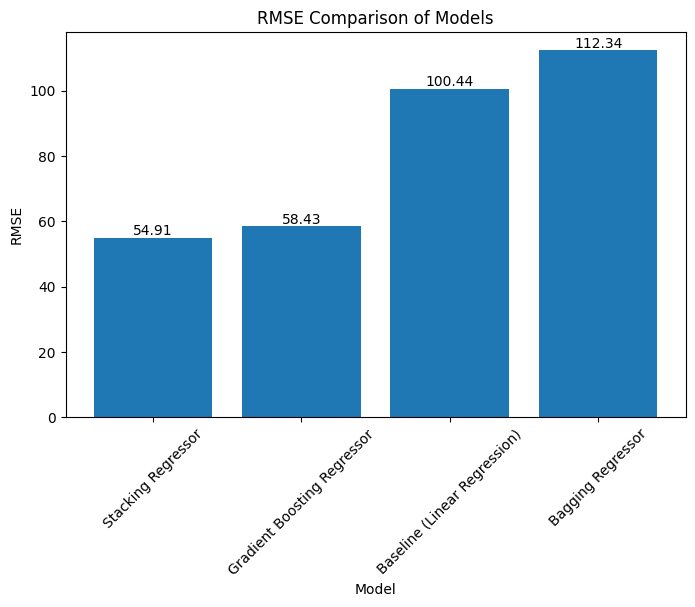

In [40]:

# Sort results for cleaner display (optional)
results_sorted = results.sort_values(by="RMSE", ascending=True)

plt.figure(figsize=(8,5))
bars = plt.bar(results_sorted["Model"], results_sorted["RMSE"])

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,   # x-position (center of bar)
        height,                            # y-position (top of bar)
        f"{height:.2f}",                   # text (rounded RMSE)
        ha='center', va='bottom'           # text alignment
    )

plt.ylabel("RMSE")
plt.xlabel("Model")
plt.title("RMSE Comparison of Models")
plt.xticks(rotation=45)
plt.show()


We can visualise from the graph **Stacking Regessor Model** performs **best** out of all models(**Low RMSE: 54.91**) , while **Bagging Regressor Performs worst**(**High RMSE: 112.34**)


### **Line CHART:**
**Here is a line chart to visualize Actual vs Predicted bike rental counts over the test set**

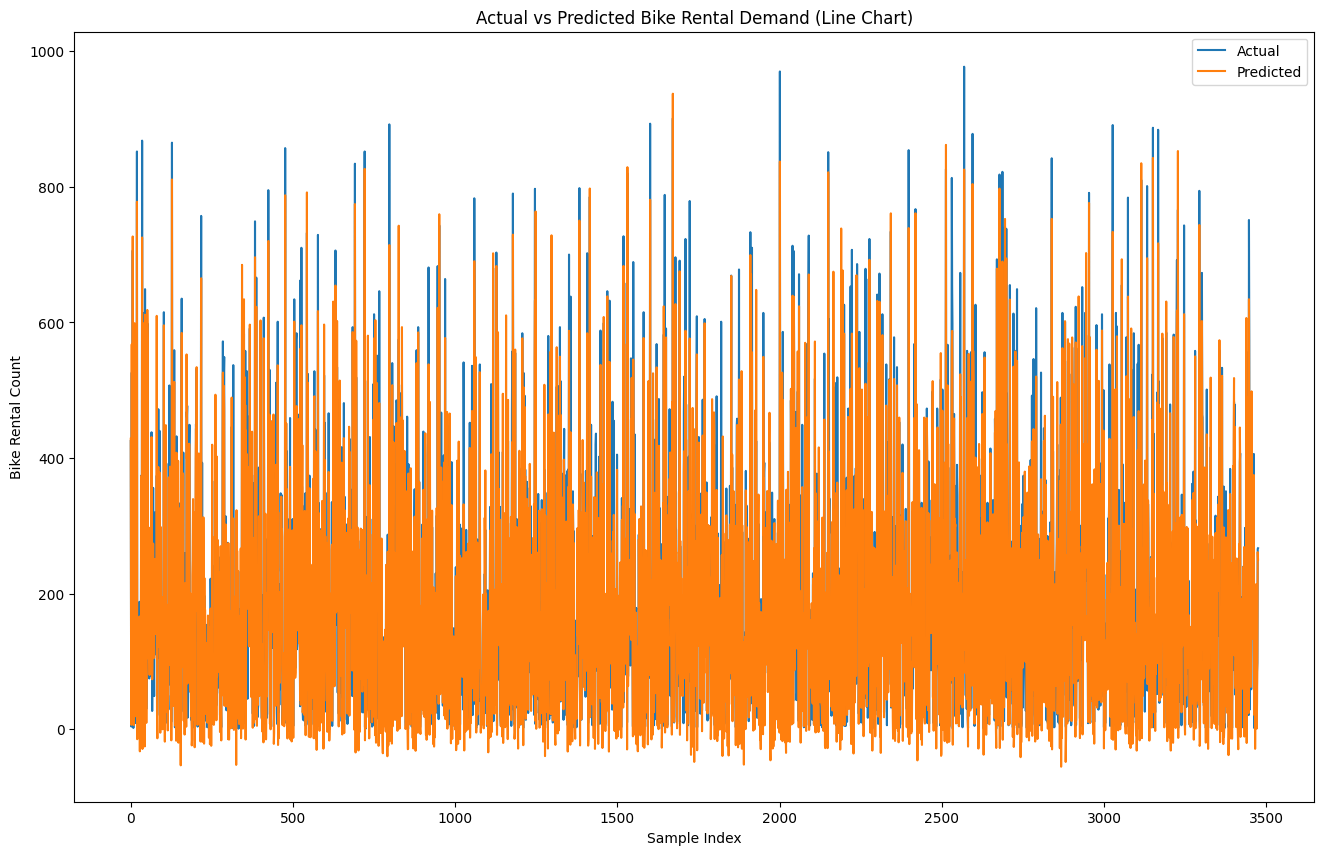

In [41]:
import matplotlib.pyplot as plt

# Use Our best model (Stacking Regressor)'s predictions
y_test_reset = y_test.reset_index(drop=True)                                    # Align indices
stack_pred_series = pd.Series(stack_pred)

plt.figure(figsize=(16,10))
plt.plot(y_test_reset, label="Actual")
plt.plot(stack_pred_series, label="Predicted")

plt.xlabel("Sample Index")
plt.ylabel("Bike Rental Count")
plt.title("Actual vs Predicted Bike Rental Demand (Line Chart)")
plt.legend()
plt.show()


**OBSERVATION : The model's predictions closely follow the actual bike rental trends but tend to underestimate demand, particularly during the highest usage periods.**

---

## **why the Stacking Regressor outperformed the Single model baseline ⁉**

We can answer this Question by Ourselves by Looking at following points :

- So, Stacking Regressor achieved the lowest RMSE (54.91), outperforming all single models, including Linear Regression (100.44) and Bagging Regressor (112.35).

- By **combining base learners** (KNN, Bagging, Gradient Boosting) **with a Ridge Regression meta-learner**, it **reduces both bias and variance, improving generalization thereby achieving the lowest RMSE on test data.**.

- **Model Diversity**: **Diverse base models** make **different errors**;  **Meta-learner optimally blends their predictions**, **capturing complex patterns** that single models miss.

---

# **Conclusion :**


In this study, we compared several regression approaches for predicting hourly bike rental demand.  
- The baseline models provided a starting performance reference, but ensemble methods demonstrated clear improvements.

- **Bagging reduced the variance of the Decision Tree model** and improved stability, while **Gradient Boosting significantly reduced bias** by learning from errors sequentially — **achieving the lowest RMSE among individual models**.  
- Finally, **the Stacking Regressor** combined the strengths of multiple diverse learners and **produced the best overall performance**, demonstrating superior generalization.

Overall, the results highlight that ensemble learning, especially **Boosting and Stacking**, effectively balances the bias-variance trade-off and leads to more accurate and reliable predictions than any single model alone.

---
